# Synthetic data Notebook
### This notebook is used to check the validity of the artificial data used in the mitosis transition project

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import Tensor
from random import random
from random import randint
from random import seed
from random import shuffle
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import utils_MNIST

## XOR Dataset

In [ ]:
dataset_size=1000
testset_size=1000
input_dim=2 #dimension in which the XOR is embedded
signal_to_noise-ratio=1. #ratio between the center of the gaussians and their std 

dataset_size = trainset_size+testset_size

#build a random matrix in all the other dimensions
matrix_random = torch.normal(0, 1, (input_dim - 2, dataset_size))

#here we build the gaussians in 2D
matrix_model_1 = torch.normal(0.5, 0.5/signal_noise_ratio, (2, round(dataset_size / 4)))
matrix_model_2 = torch.normal(-0.5, 0.5/signal_noise_ratio, (2, round(dataset_size / 4)))
means_3 = torch.tensor(np.array([[0.5], [-0.5]])).repeat(1, round(dataset_size / 4))
means_4 = torch.tensor(np.array([[-0.5], [0.5]])).repeat(1, round(dataset_size / 4))
matrix_model_3 = torch.normal(means_3, 0.5/signal_noise_ratio)
matrix_model_4 = torch.normal(means_4, 0.5/signal_noise_ratio)

#put them together in a big matrix
big_matrix = torch.cat((matrix_model_1, matrix_model_2, matrix_model_3, matrix_model_4), 1)
big_matrix = torch.cat((matrix_random, big_matrix), 0)

#shuffle the dimensions
big_matrix = big_matrix[torch.randperm(input_dim)]

#shuffle the samples
big_matrix = torch.transpose(big_matrix, 0, 1)
labels = torch.cat((torch.zeros(round(dataset_size / 2)), torch.ones(round(dataset_size / 2))), 0)
indexes=torch.randperm(dataset_size)
labels_dataset=labels[indexes]
X_dataset=big_matrix[indexes]

#create the dataset
train_set = CustomDataSet(X_dataset[:trainset_size], labels_dataset[:trainset_size], input_dim)
test_set = CustomDataSet(X_dataset[trainset_size:], labels_dataset[trainset_size:], input_dim)
#torch.save(train_set, f'./data/XOR_{input_dim}_dimension_{signal_noise_ratio}_ratio_train_{trainset_size}_samples.pt')
#torch.save(test_set, f'./data/XOR_{input_dim}_dimension_{signal_noise_ratio}_ratio_test_{testset_size}_samples.pt')

In [84]:
def create_XOR_dataset(trainset_size, testset_size, input_dim,signal_noise_ratio):
    dataset_size = trainset_size+testset_size
    matrix_random = torch.normal(0, 1, (input_dim - 2, dataset_size))
    matrix_model_1 = torch.normal(0.5, 0.5/signal_noise_ratio, (2, round(dataset_size / 4)))
    matrix_model_2 = torch.normal(-0.5, 0.5/signal_noise_ratio, (2, round(dataset_size / 4)))
    means_3 = torch.tensor(np.array([[0.5], [-0.5]])).repeat(1, round(dataset_size / 4))
    means_4 = torch.tensor(np.array([[-0.5], [0.5]])).repeat(1, round(dataset_size / 4))
    matrix_model_3 = torch.normal(means_3, 0.5/signal_noise_ratio)
    matrix_model_4 = torch.normal(means_4, 0.5/signal_noise_ratio)
    big_matrix = torch.cat((matrix_model_1, matrix_model_2, matrix_model_3, matrix_model_4), 1)
    big_matrix = torch.cat((matrix_random, big_matrix), 0)
    big_matrix = big_matrix[torch.randperm(input_dim)]
    big_matrix = torch.transpose(big_matrix, 0, 1)
    labels = torch.cat((torch.zeros(round(dataset_size / 2)), torch.ones(round(dataset_size / 2))), 0)
    indexes=torch.randperm(dataset_size)
    labels_dataset=labels[indexes]
    X_dataset=big_matrix[indexes]
    train_set = utils_MNIST.CustomDataSet(X_dataset[:trainset_size], labels_dataset[:trainset_size], input_dim)
    test_set = utils_MNIST.CustomDataSet(X_dataset[trainset_size:], labels_dataset[trainset_size:], input_dim)
    torch.save(train_set, f'./data/XOR_{input_dim}_dimension_{signal_noise_ratio}_ratio_train_{trainset_size}_samples.pt')
    torch.save(test_set, f'./data/XOR_{input_dim}_dimension_{signal_noise_ratio}_ratio_test_{testset_size}_samples.pt')


## Teacher-Student setup
### Creation of the teacher dataset

In [81]:
teacher_width=4
sample_size=1000
depth=2
input_dim=100
noise_ratio=1.
output_size=1

#inputs are gaussian
inputs=torch.normal(0,1,(sample_size,round(input_dim)))

#the teacher is a small 2-layer neural network
teacher=utils_MNIST.fully_connected_new(teacher_width, depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)

In [82]:
#labels are generated through the teacher network
outputs=teacher(inputs)

#add some noise 
mean=torch.mean(outputs).item()
std=torch.std(outputs).item()
labels=torch.normal(0,(std/noise_ratio),(sample_size,1))+outputs

#make binary labels and balanced classes
labels=labels-mean
labels[labels<0]=0
labels[labels>0]=1
labels=torch.squeeze(labels)

#create the dataset
train_set = utils_MNIST.CustomDataSet(inputs[:trainset_size], labels[:trainset_size], input_dim)
test_set = utils_MNIST.CustomDataSet(inputs[trainset_size:], labels[trainset_size:], input_dim)
#torch.save(train_set, f'./data/teacher_{input_dim}_dimension_{teacher_width}_width_{noise_ratio}_noise_train_{trainset_size}_samples.pt')
#torch.save(test_set, f'./data/teacher_{input_dim}_dimension_{teacher_width}_width_{noise_ratio}_noise_test_{testset_size}_samples.pt')

In [ ]:
def create_teacher_dataset(trainset_size, testset_size, input_dim, teacher_width, noise_ratio):
    depth=2
    sample_size=trainset_size+testset_size
    teacher=utils_MNIST.fully_connected_new(teacher_width, depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
    inputs=torch.normal(0,1,(sample_size,round(input_dim)))
    outputs=teacher(inputs)
    mean=torch.mean(outputs).item()
    std=torch.std(outputs).item()
    labels=torch.normal(0,(std/noise_ratio),(sample_size,1))+outputs
    labels=labels-mean
    labels[labels<0]=0
    labels[labels>0]=1
    labels=torch.squeeze(labels)
    train_set = utils_MNIST.CustomDataSet(inputs[:trainset_size], labels[:trainset_size], input_dim)
    test_set = utils_MNIST.CustomDataSet(inputs[trainset_size:], labels[trainset_size:], input_dim)
    #torch.save(train_set, f'./data/teacher_{input_dim}_dimension_{teacher_width}_width_{noise_ratio}_noise_train_{trainset_size}_samples.pt')
    #torch.save(test_set, f'./data/teacher_{input_dim}_dimension_{teacher_width}_width_{noise_ratio}_noise_test_{testset_size}_samples.pt')
    print('Teacher dataset created')

In [ ]:
create_teacher_dataset(10,10,10,4,2)

## Extended XOR
### Try with the generalized case! Here we use more gaussians to generated the data, although they continue to live in a 2-dimensional manifold

In [85]:
trainset_size=1000
testset_size=10000
square_edge=3
input_dim=20
signal_noise_ratio=2.
dataset_size=trainset_size+testset_size
area=square_edge**2

#from edge and signal_noise_ratio to location of the means and standard deviation
std=1/(1+signal_noise_ratio*(square_edge-1))
distance=2/(square_edge-1+1/signal_noise_ratio)

#again, random matrix for the embedding dimensions
matrix_random = torch.normal(0, 1, (dataset_size,input_dim-2))

#create the "models" and shuffle
means=[]
for i in range(square_edge):
    for j in range(square_edge):
        means.append(torch.unsqueeze(torch.Tensor([-1+std+i*distance,-1+std+j*distance]),0))
shuffle(means)
print(means)

[tensor([[ 0.0000, -0.8000]]), tensor([[-0.8000,  0.0000]]), tensor([[0., 0.]]), tensor([[0.0000, 0.8000]]), tensor([[0.8000, 0.8000]]), tensor([[ 0.8000, -0.8000]]), tensor([[-0.8000,  0.8000]]), tensor([[0.8000, 0.0000]]), tensor([[-0.8000, -0.8000]])]


In [86]:
#create the models for the dataset
tensor=torch.empty(0,2)
for i in range(round(dataset_size/2)):
    tensor=torch.cat((tensor,means[randint(0,round(area/2)-1)]),0)
for i in range(round(dataset_size/2)):
    tensor=torch.cat((tensor,means[randint(round(area/2),area-1)]),0)

#from the models to the gaussians    
small_matrix=torch.normal(tensor,std)

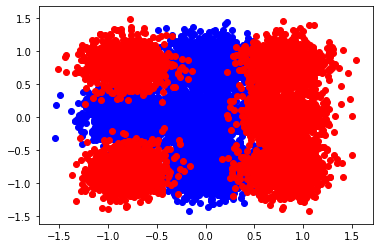

In [87]:
#visualization of the gaussians! Also, for small values of the edge, it is quite likely that the gaussians end up
#being linearly separable, so better check visually
x=torch.transpose(small_matrix,0,1)[0][:round(dataset_size/2)]
y=torch.transpose(small_matrix,0,1)[1][:round(dataset_size/2)]
plt.scatter(x, y,color='blue')
x1=torch.transpose(small_matrix,0,1)[0][round(dataset_size/2):]
y1=torch.transpose(small_matrix,0,1)[1][round(dataset_size/2):]
plt.scatter(x1,y1,color='red')

In [88]:
#embed the data in the higher dimension
big_matrix=torch.cat((small_matrix,matrix_random),1)

#shuffle the data
labels = torch.cat((torch.zeros(round(dataset_size / 2)), torch.ones(round(dataset_size / 2))), 0)
indexes=torch.randperm(dataset_size)
labels_dataset=labels[indexes]
X_dataset=big_matrix[indexes]

#shuffle the dimensions
X_dataset=torch.transpose(torch.transpose(X_dataset,0,1)[torch.randperm(input_dim)],0,1)

#create and save dataset
train_set = utils_MNIST.CustomDataSet(X_dataset[:trainset_size], labels_dataset[:trainset_size], input_dim)
test_set = utils_MNIST.CustomDataSet(X_dataset[trainset_size:], labels_dataset[trainset_size:], input_dim)
torch.save(train_set, f'./data/generalized_XOR_{square_edge}_edge_{input_dim}_dimension_{signal_noise_ratio}_ratio_train_{trainset_size}_samples.pt')
torch.save(test_set, f'./data/generalized_XOR_{square_edge}_edge_{input_dim}_dimension_{signal_noise_ratio}_ratio_test_{testset_size}_samples.pt')